In [15]:
# --- Standard library ---
import os
import re
import operator
from typing import TypedDict, Annotated, Literal, Sequence

# --- LangGraph ---
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition, ToolNode


# --- LangChain Core ---
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool
import requests

# --- LangChain Community ---
from langchain_community.document_loaders import ArxivLoader, PyMuPDFLoader, WebBaseLoader
from langchain_community.vectorstores import FAISS

# --- LangChain OpenAI ---
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# --- LangChain Tools ---
from langchain.tools.retriever import create_retriever_tool

# --- LangChain Hub ---
from langchain import hub

# --- LangChain Text Splitters ---
from langchain_text_splitters import RecursiveCharacterTextSplitter

# --- Other third-party ---
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled
from langchain_community.tools import TavilySearchResults


In [16]:
load_dotenv()

True

In [17]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

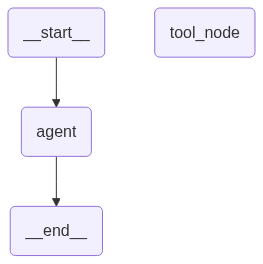

In [18]:
search_app

In [20]:
search_app.invoke({"messages": [HumanMessage(content="How is the weather in Lahore?")]})

{'messages': [HumanMessage(content='How is the weather in Lahore?', additional_kwargs={}, response_metadata={}, id='bd3bfd90-fc67-4522-9bc2-19e4b479b1b8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e9nYL1YbotrZUxQUv4oe3j7f', 'function': {'arguments': '{"query":"current weather in Lahore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CEvihHGLiXQdjt4ou1vK0nNI6iufs', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2206c539-d0cc-4eee-82bf-48504f3bab59-0', tool_calls=[{'name': 'tavily_search_re

## Case 1: Shared Schema (Direct Embedding)

In [21]:
# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"messages": [HumanMessage(content="How is the weather in Lahore?")]})
result

{'messages': [HumanMessage(content='How is the weather in Lahore?', additional_kwargs={}, response_metadata={}, id='30d08dae-6bdc-42c5-8423-29cf27ab20d4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b7PMaOwNlcI195NLUViQfkho', 'function': {'arguments': '{"query":"Lahore weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 86, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CEvoYwkQbpr86F9kNFX4QEDwNclnE', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ade66fdf-9cdf-461c-9f0a-df183d336b6d-0', tool_calls=[{'name': 'tavily_search_results

## Case 2: Different Schema (Invoke with Transformation)

In [12]:
# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }
    
    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)
    
    # Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraph
parent_graph.add_node("search_agent", search_agent)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"query": "How is the weather in Chennai?", "response": ""})
print(result)

{'query': 'How is the weather in Chennai?', 'response': "It seems that I couldn't find the current weather information for Chennai directly. However, you can check reliable sources like [AccuWeather](https://www.accuweather.com/en/in/chennai/206671/september-weather/206671) or other weather websites for the latest updates on the weather conditions in Chennai."}
